# Table of contents
- [Machine learning for forecasting](#Machine-learning-for-forecasting)
- [Recursive autoregressive forecasting](#Recursive-autoregressive-forecasting)
- [Recursive autoregressive forecasting with exogenous variables](#Recursive-autoregressive-forecasting-with-exogenous-variables)
- [Recursive autoregressive forecasting with custom predictors](#Recursive-autoregressive-forecasting-with-custom-predictors)
- [Direct multi step forecasting](#Direct-multi-step-forecasting)


Most of the content of this notebook is based on the following resource:
- Amat Rodrigo, J., & Escobar Ortiz, J. skforecast (Version 0.6.0) [Computer software], available [online](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html) (last visited Dec. 2022). The present work is an adaptation of the work by Joaquín Amat Rodrigo, licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

- "[Forecasting: principles and practice, 3rd edition](https://otexts.com/fpp3/):
    - Author: Hyndman, R.J., & Athanasopoulos, G. (2021) 
    - Released: 2021
    - Publisher: OTexts - Melbourne, Australia.
    - ISBN: 9780987507136 

- "[Practical Time Series Analysis. Prediction with Statistics & Machine Learning](https://www.oreilly.com/library/view/practical-time-series/9781492041641/)"
    - Author: Aileen Nielsen
    - Released: October 2019
    - Publisher: O'Reilly Media, INC. 
    - ISBN: 9781492041658


The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

<div>
<img src='./images/forecasting_multi-step_en.gif' width="600"/>
</div>

### The basic steps for forecasting
1. Problem definition.
2. Gathering information.
    -  it includes statistical data, but also the accumulated expertise of the people who collect the data and use the forecasts.
3. Preliminary (exploratory) analysis.
    - Are there consistent patterns? Is there a significant trend? Is seasonality important? Is there evidence of the presence of business cycles? Are there any outliers in the data? How strong are the relationships among the variables available for analysis?
4. Choosing and fitting models.
    - The study of time series prediction models is an extremely broad area of research spanning several fields. The best model to use depends on the availability of historical data, the strength of relationships between the forecast variable and any explanatory variables, and the way in which the forecasts are to be used. Each model is based on a set of assumptions (explicit and implicit) and usually involves one or more parameters which must be estimated using the known historical data. Most common approaches include *regression models*, *exponential smoothing methods*, *ARIMA models and variations* down to cutting edge *neural network* architectures.
5. Using and evaluating a forecasting model.

**This document describes** how to use `scikit-learn` regression models to perform forecasting on time series. Specifically, it introduces [`skforecast`](https://joaquinamatrodrigo.github.io/skforecast/), a simple library that contains the classes and functions necessary to adapt any `scikit-learn` regression model to forecasting problems.
You can access more examples here: [skforecast-examples](https://joaquinamatrodrigo.github.io/skforecast/latest/examples/examples.html). Notice that skforecast is a recent and not yet fully stable library: you may want to explore also other libraries, e.g. [`sktime`](https://www.sktime.org/en/stable/).

As anticipated, this is only one possible family of approaches, but it is not the only way forward for timeseries forecasting. Model selection typically takes place after an in-depth exploratory analysis and/or comparative evaluation. This notebook, however, only provides basic concepts related to the timeseries forecasting approach with machine learning methods.

## Machine learning for forecasting

In order to apply machine learning models to forecasting problems, the time series has to be transformed into a matrix in which each value is related to the time window (lags) that precedes it.

In a time series context, a lag with respect to a time step $t$ is defined as the values of the series at previous time steps. For example, lag 1 is the value at time step $t − 1$ and lag $m$ is the value at time step $t − m$.

<img src="./images/transform_timeseries.gif" style="width: 550px;">
<br>

<center><font size='2.5'> <i>Time series transformation into a matrix of 5 lags and a vector with the value of the series that follows each row of the matrix.</i></font></center>

This type of transformation also allows to include additional variables.

<img src="./images/matrix_transformation_with_exog_variable.png" style="width: 550px;">

<center><font size='2.5'> <i>Time series transformation including an exogenous variable.</i></font></center>

Once data have been rearranged into the new shape, any regression model can be trained to predict the next value (step) of the series. During model training, every row is considered a separate data instance, where values at lags 1, 2, ... $p$ are considered predictors for the target quantity of the time series at time step $p + 1$. 

### Multi-Step Time Series Forecasting

When working with time series, it is seldom needed to predict only the next element in the series ($t_{+1}$). Instead, the most common goal is to predict a whole future interval (($t_{+1}$), ..., ($t_{+n}$)) or a far point in time ($t_{+n}$). Several strategies allow generating this type of prediction.

#### Recursive multi-step forecast

Since the value $t_{n-1}$ is required to predict $t_{n}$, and $t_{n-1}$ is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the `ForecasterAutoreg` and `ForecasterAutoregCustom` classes.

<div>
<img src='./images/diagram-recursive-mutistep-forecasting.png' width="650"/>
</div>

<center><font size='2.5'> <i>Recursive multi-step prediction process diagram to predict 3 steps into the future using the last 4 lags of the series as predictors.</i></font></center>

#### Direct multi-step forecast

Direct multi-step forecasting consists of training a different model for each step of the forecast horizon. For example, to predict the next 5 values of a time series, 5 different models are trained, one for each step. As a result, the predictions are independent of each other.

<p align="center"><img src="./images/diagram-direct-multi-step-forecasting.png" style="width: 700px"></p>

<center><font size='2.5'> <i>Direct multi-step prediction process diagram to predict 3 steps into the future using the last 4 lags of the series as predictors.</i></font></center>


The main complexity of this approach is to generate the correct training matrices for each model. The `ForecasterAutoregDirect` class of the **skforecast** library automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.

<img src="./images/diagram_skforecast_multioutput.png" style="width: 900px;">

<center><font size='2.5'> <i>Transformation of a time series into matrices to train a direct multi-step forecasting model</i></font></center>

#### Multiple output forecast
Some machine learning models, such as long short-term memory (LSTM) neural network, can predict simultaneously several values of a sequence (one-shot). This strategy is not currently implemented in **skforecast** library.


## Recursive autoregressive forecasting

A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to create an autoregressive model capable of predicting future monthly expenditures.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

### Data 
The data used in the examples of this document have been obtained from the book [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [2]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')
# data = pd.read_csv('dataset/local_h2o_exog.csv',index_col = 0)
data = data.rename(columns={'fecha': 'date'})
data

,date,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


The column `date` has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of `Pandas` functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [3]:
# Data preparation
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()
len(data)

195

When setting a frequency with the `asfreq()` method, `Pandas` fills the gaps that may exist in the time series with the value of `Null` to ensure the indicated frequency. Therefore, it should be checked if missing values have appeared after this transformation.

In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


The last 36 months are used as the test set to evaluate the predictive capability of the model.

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


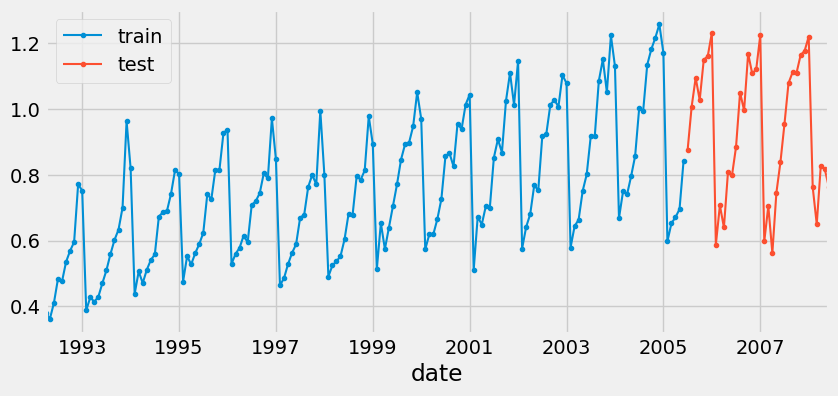

In [5]:
# Split data into train-test
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train',marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test',marker = 'o', markersize = 3)
ax.legend();


### ForecasterAutoreg

With the `ForecasterAutoreg` class, a model is created and trained from a `RandomForestRegressor` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [6]:
ForecasterAutoreg?

In [7]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-14 16:15:09 
Last fit date: 2022-12-14 16:15:09 
Skforecast version: 0.6.0 
Python version: 3.10.8 

In [8]:
dir(forecaster)

['X_train_col_names',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_create_lags',
 '_estimate_boot_interval',
 '_recursive_predict',
 'create_sample_weights',
 'create_train_X_y',
 'creation_date',
 'exog_col_names',
 'exog_type',
 'fit',
 'fit_date',
 'fitted',
 'get_feature_importance',
 'in_sample_residuals',
 'included_exog',
 'index_freq',
 'index_type',
 'lags',
 'last_window',
 'max_lag',
 'out_sample_residuals',
 'predict',
 'predict_interval',
 'python_version',
 'regressor',
 'set_lags',
 'set_out_sample_residuals',
 'set_params',
 'skforcast_version',
 'source_code_weight_func',
 'summary',
 'training_r

In [9]:
X,y = forecaster.create_train_X_y(data_train['y'])

In [10]:
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
date,,,,,,
1992-10-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808
1992-11-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801
1992-12-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534
1993-01-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389
1993-02-01,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463
...,...,...,...,...,...,...
2005-02-01,1.170690,1.257238,1.216037,1.181011,1.134432,0.994864
2005-03-01,0.597639,1.170690,1.257238,1.216037,1.181011,1.134432
2005-04-01,0.652590,0.597639,1.170690,1.257238,1.216037,1.181011


In [11]:
y

date
1992-10-01    0.568606
1992-11-01    0.595223
1992-12-01    0.771258
1993-01-01    0.751503
1993-02-01    0.387554
                ...   
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, Length: 153, dtype: float64

### Predictions
Once the model is trained, the test data is predicted (36 months into the future).

In [12]:
forecaster.predict?
# implements recursive autoregressive forecasting

In [13]:
# Predictions
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

### How to evaluate predictions
- Plot the outputs of your model for the test data set.
- Plot the **residuals** (i.e., difference between the training observations and the corresponding fitted values) of your model over time:
    - If the residuals are not homogenous over time, your model is likely to be underspecified (i.e., has a low capacity). The temporal behavior of the residuals can point you toward additional parameters needed in your model to describe the temporal behavior.
    
- Test your model against a simple temporally aware naive model (baseline):
    - A common naive model is that every forecast for time $t$ should be the value at time $t – 1$ (often referred to as *persistence*). If you assume you can rely on such measurement and your model is not beating such a simple model, there isn't any justification for it. 

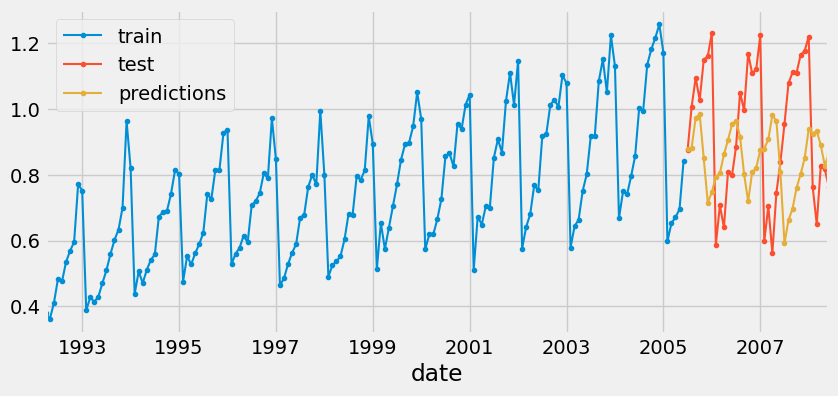

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train',marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test',marker = 'o', markersize = 3)
predictions.plot(ax=ax, label='predictions',marker = 'o', markersize = 3)
ax.legend();

### Prediction error in the test set
The error that the model makes in its predictions is quantified.

The error can be defined as

<center>$e_{T+h}=y_{T+h}-\hat{y}_{T+h|T}$ 

where training data is given by $\{y_1, \dots, y_T\}$ and test data is given by $\{y_{T+1}, y_{T+2}, \dots\}$
    
**Forecast accuracy** can be measured by summarising the forecast errors in different ways.



#### Scale-dependent errors
By definition, the forecast errors are on the same scale as the data. Accuracy measures that are based only on $e_t$ are therefore scale-dependent and cannot be used to make comparisons between series that involve different units.    

- **Mean absolute error**: $\text{MAE}=\text{mean}(|e_t|)$
- **Root mean squared error**: $\text{RMSE}=\sqrt{\text{mean}(e^2_t)}$

#### Percentage errors
Percentage errors have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets. 

- **Mean absolute percentage error**: $\text{MAPE}=\text{mean}(|pt|) =\text{mean}(|100\cdot\frac{e_t}{y_t}|) $

#### Other commonly used metrics
- **Mean squared error**: $\text{MSE}=\text{mean}(e^2_t)$


... and many others that compensate for known issues of the above metrics.

In this notebook, the metric used is the mean squared error (mse).

In [15]:
# Test error
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07326833976120374


### Hyperparameter tuning
The trained `ForecasterAutoreg` uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, such hyperparameters configuration may not be optimal. In order to identify the best combination of lags and hyperparameters, the `Skforecast` library provides the `grid_search_forecaster` function. It compares the results obtained with each model configuration.

For more detailed documentation, check the docs: [skforecast grid search forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

In [16]:
data_train

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2005-02-01,0.597639,1.520544,1.784523
2005-03-01,0.652590,1.506290,1.678839
2005-04-01,0.670505,1.487660,1.569732


In [17]:
len(data_train)*0.5

79.5

In [18]:
data_train['y']

date
1992-04-01    0.379808
1992-05-01    0.361801
1992-06-01    0.410534
1992-07-01    0.483389
1992-08-01    0.475463
                ...   
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, Length: 159, dtype: float64

In [19]:
# Hyperparameter Grid search
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = True
               )

Number of models compared: 30.


loop param_grid:   0%|                                             | 0/15 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:   7%|██▍                                  | 1/15 [00:00<00:04,  3.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  13%|████▉                                | 2/15 [00:00<00:06,  2.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  20%|███████▍                             | 3/15 [00:01<00:08,  1.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  27%|█████████▊                           | 4/15 [00:02<00:09,  1.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  33%|████████████▎                        | 5/15 [00:04<00:10,  1.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  40%|██████████████▊                      | 6/15 [00:04<00:07,  1.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  47%|█████████████████▎                   | 7/15 [00:05<00:05,  1.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  53%|███████████████████▋                 | 8/15 [00:06<00:05,  1.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  60%|██████████████████████▏              | 9/15 [00:07<00:05,  1.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  67%|████████████████████████            | 10/15 [00:09<00:05,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  73%|██████████████████████████▍         | 11/15 [00:09<00:03,  1.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  80%|████████████████████████████▊       | 12/15 [00:10<00:02,  1.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  87%|███████████████████████████████▏    | 13/15 [00:11<00:01,  1.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  93%|█████████████████████████████████▌  | 14/15 [00:12<00:00,  1.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:   0%|                                             | 0/15 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:   7%|██▍                                  | 1/15 [00:00<00:04,  3.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  13%|████▉                                | 2/15 [00:00<00:06,  2.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  20%|███████▍                             | 3/15 [00:01<00:08,  1.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  27%|█████████▊                           | 4/15 [00:03<00:10,  1.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  33%|████████████▎                        | 5/15 [00:04<00:11,  1.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  40%|██████████████▊                      | 6/15 [00:05<00:07,  1.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  47%|█████████████████▎                   | 7/15 [00:05<00:06,  1.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  53%|███████████████████▋                 | 8/15 [00:06<00:06,  1.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  60%|██████████████████████▏              | 9/15 [00:07<00:05,  1.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  67%|████████████████████████            | 10/15 [00:09<00:05,  1.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  73%|██████████████████████████▍         | 11/15 [00:09<00:03,  1.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  80%|████████████████████████████▊       | 12/15 [00:10<00:02,  1.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  87%|███████████████████████████████▏    | 13/15 [00:11<00:01,  1.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop param_grid:  93%|█████████████████████████████████▌  | 14/15 [00:12<00:01,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 80
    Number of folds: 3
    Number of steps per fold: 36
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1998-10-01 00:00:00  (n=79)
    Validation: 1998-11-01 00:00:00 -- 2001-10-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00  (n=115)
    Validation: 2001-11-01 00:00:00 -- 2004-10-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2004-10-01 00:00:00  (n=151)
    Validation: 2004-11-01 00:00:00 -- 2005-06-01 00:00:00  (n=8)




loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:28<00:00, 14.25s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 0.012717576051942708



In [20]:
# Grid Search results
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 200}",0.012718,3,200
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 300}",0.012809,3,300
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012836,3,500
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.012858,3,100
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 400}",0.012944,3,400
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.013248,5,500
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.013289,5,200
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 300}",0.013359,10,300
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.013364,5,100
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.013435,10,500


The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 200}.

The goodness of each configuration is evaluated on the training data (159 sample), by exploiting backtesting.

### Backtesting

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it can be considered as a special type of temporally aware cross-validation, applied to previous period(s).

**Backtesting with refit and increasing training size (fixed origin)**

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<img src="./images/diagram-backtesting-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and retraining at each iteration.</i></font></center>

**Backtesting with refit and fixed training size (rolling origin)**

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

<img src="./images/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and a training set of constant size.</i></font></center>

**Backtesting without refit**

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest data available, so it may lose predictive capacity over time.

<img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and no retraining at each iteration.</i></font></center>

The **skforecast** library has the mentioned [backtesting strategies](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html#backtesting) implemented. Regardless of which one is used, it is important not to include test data in the search process to avoid overfitting problems.


In our example:
- first "fold": actual training set is composed of the first 79 (out of 159) samples. Train on such training set, test on the subsequent `steps` (=36) samples with recursive autoregressive forecasting.
- second "fold": as `fixed_train_size = False` and `refit = True`, include the 36 samples in the training set (79+36=115) and fit the model from scratch. Test on the subsequent `steps` (=36) samples with recursive autoregressive forecasting.
- third "fold": as `fixed_train_size = False` and `refit = True`, include the 36 samples in the training set (79+36+36=151) and fit the model from scratch. Test on the subsequent `steps` (=8, just the remaining ones) samples with recursive autoregressive forecasting.

*Manual* implementation follows.

Test error (mse): 0.010329106169185982 - evaluated on 36 observations
Test error (mse): 0.011683526264598867 - evaluated on 36 observations
Test error (mse): 0.02811891456739525 - evaluated on 8 observations

Test error (weighted avg mse): 0.012718


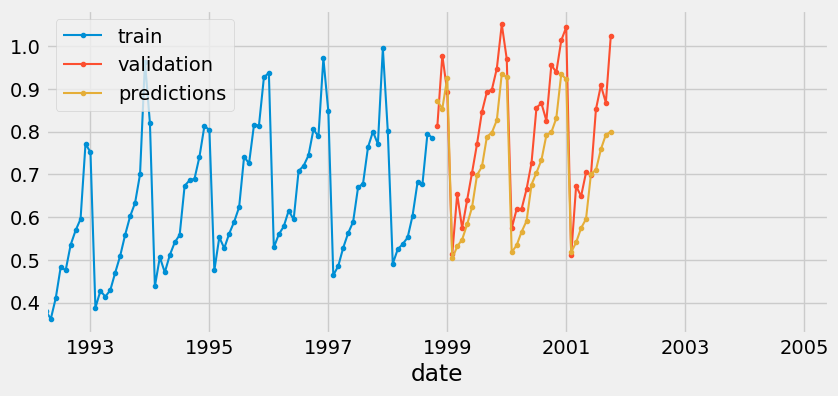

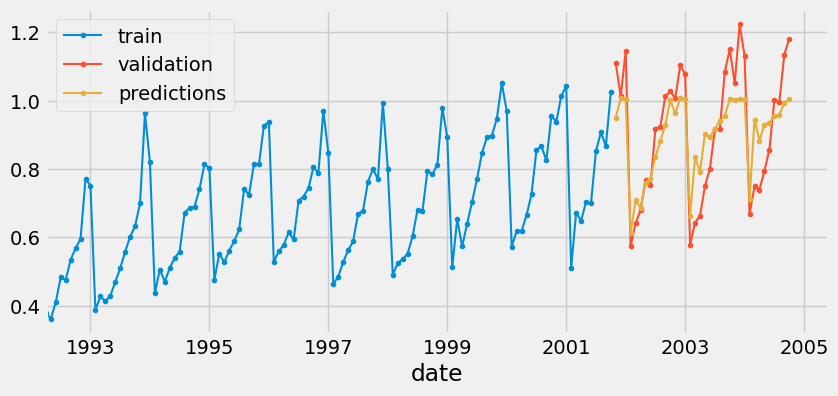

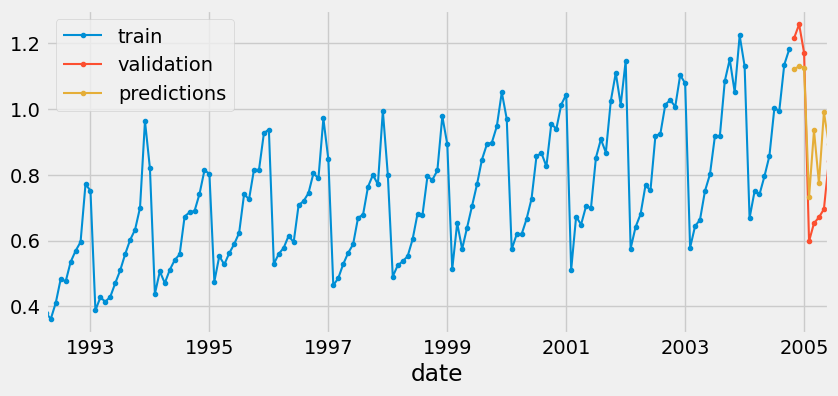

In [21]:
error_mse_list, observation_list = [],[]

n_estimators = 200
max_depth = 3
lags = 20

for i in range(3): 
    forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, random_state=123),
                    lags      = lags
                 )

    steps = 36
    forecaster.fit(y=data_train['y'][:79+steps*i])
    y_true = data_train['y'][79+steps*i:79+steps*(i+1)]
    
    predictions = forecaster.predict(steps=len(y_true))
    error_mse_1 = mean_squared_error(y_true = y_true,y_pred = predictions)
    error_mse_list.append(error_mse_1)
    observation_list.append(len(y_true))
    print(f"Test error (mse): {error_mse_1} - evaluated on {len(y_true)} observations")
    fig, ax = plt.subplots(figsize=(9, 4))
    data_train['y'][:79+steps*i].plot(ax=ax, label='train',marker = 'o', markersize = 3)
    data_train['y'][79+steps*i:79+steps*(i+1)].plot(ax=ax, label='validation',marker = 'o', markersize = 3)
    predictions.plot(ax=ax, label='predictions',marker = 'o', markersize = 3)
    plt.xlim((267.0, 425.0))
    ax.legend(loc=2)
print()
print(f'Test error (weighted avg mse): {np.round(np.average(error_mse_list,weights = observation_list),6)}')

### Final model
Finally, a `ForecasterAutoreg` is trained with the optimal configuration found by validation. This step is not necessary if `return_best = True` is specified in the `grid_search_forecaster` function.

In [22]:
# Create and train forecaster with the best hyperparameters
regressor = RandomForestRegressor(max_depth=3, n_estimators=200, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [23]:
# Predictions
steps = 36
predictions = forecaster.predict(steps=steps)

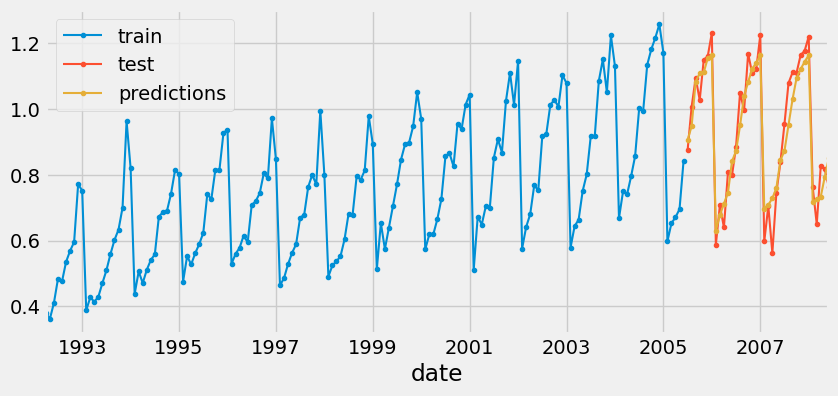

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train',marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test',marker = 'o', markersize = 3)
predictions.plot(ax=ax, label='predictions',marker = 'o', markersize = 3)
ax.legend();

In [25]:
# Test error
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004255953572840445


The optimal combination of hyperparameters significantly reduces test error.

### Feature importance

Since the `ForecasterAutoreg` object uses `Scikit-learn` models, the importance of each feature (predictor) can be accessed once trained. When the regressor used is a `LinearRegression()`, `Lasso()` or `Ridge()`, the coefficients of the model reflect their importance. In `GradientBoostingRegressor()` or `RandomForestRegressor()` regressors, the importance of each feature is based on impurity, according to the splitting criterion adopted.

Indeed, the `forecaster.get_feature_importance()` method only returns values if the regressor used within the forecaster has the attribute `coef_` or `feature_importances_`.

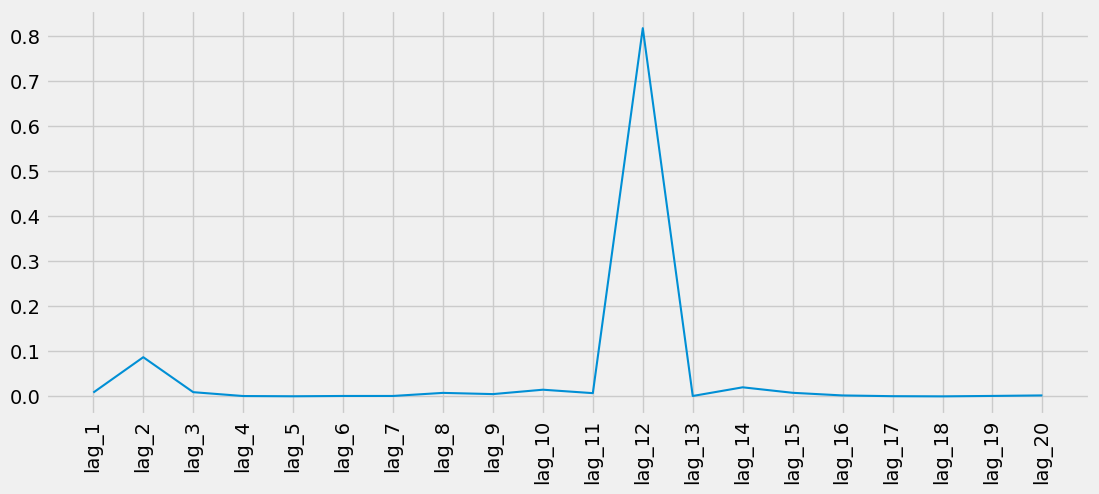

In [26]:
# Predictors importance
featureimportance = forecaster.get_feature_importance()
ax = featureimportance['importance'].plot(figsize = (12,5))
ax.set_xticks(range(len(featureimportance['feature'].values)),featureimportance['feature'].values,rotation = 90);

The signal somehow exhibits a periodic pattern and the value of 12 roughly corresponds to the period of the signal.

### Prediction Interval

Hyndman and Athanasopoulos list in their book *Forecasting: Principles and Practice* [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model are distributed in a normal way. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in the **Skforecast** library (only available for `ForecasterAutoreg` and ForecasterAutoregCustom). 

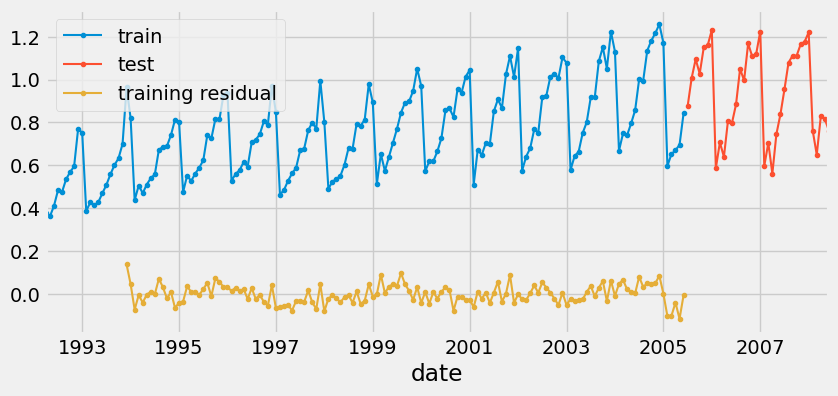

In [27]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train',marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test',marker = 'o', markersize = 3)
forecaster.in_sample_residuals.plot(ax=ax, label='training residual',marker = 'o', markersize = 3)
ax.legend();


The key intuition behind bootstrapping is reported below (from [this book section](https://otexts.com/fpp3/prediction-intervals.html#prediction-intervals-from-bootstrapped-residuals)):

The next observation of a time series can be simulated using

<center>$y_{T+1}=\hat{y}_{T+1|T}+e_{T+1}$<center>

where $\hat{y}_{T+1|T}$ is the one-step forecast and $e_{T+1}$ is a unknown future error.  However, assuming future errors will be similar to past errors, we can replace $e_{T+1}$ by sampling from the collection of errors we have seen in the past (i.e., the residuals), and then repeat, for future observations.
Doing this repeatedly with different random sampling, we obtain many possible futures.

<div>
<img src='./images/bootstrapped-prediction-interval.gif'/>
</div>

<center><font size='2.5'> <i>Diagram of how to create prediction intervals using bootstrapping.</i></font></center>


Then, for each timestamp, we can select two percentiles of the sorted array of all predicted values, which will  represent the lower bound and the upper bound of the prediction interval. For example, the prediction interval (1, 99) can be expected to contain the true prediction value in 98% of the cases.


In [28]:
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 100
              )

predictions

,pred,lower_bound,upper_bound
2005-07-01,0.905682,0.802761,0.995014
2005-08-01,0.947592,0.846623,1.045164
2005-09-01,1.083305,0.954932,1.221119
2005-10-01,1.107976,0.995811,1.182195
2005-11-01,1.111316,1.052605,1.225260
2005-12-01,1.154407,1.024153,1.238727
2006-01-01,1.162747,1.076256,1.232156
2006-02-01,0.630310,0.529340,0.768769
2006-03-01,0.676998,0.573777,0.770643
2006-04-01,0.711735,0.595649,0.791123


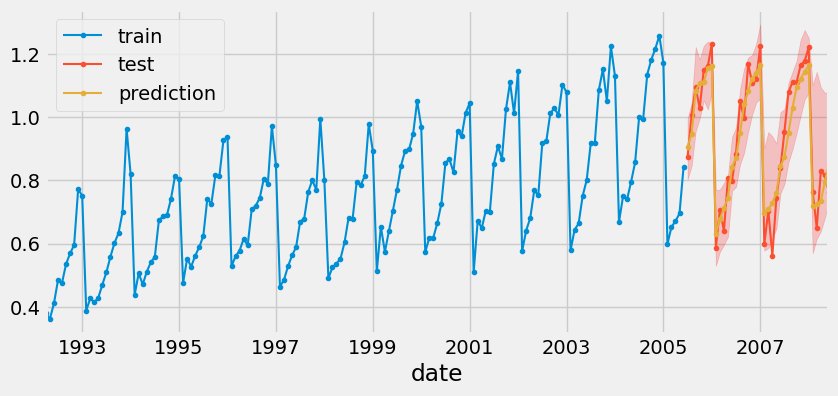

In [29]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train', marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test', marker = 'o', markersize = 3)
predictions['pred'].plot(ax=ax, label='prediction', marker = 'o', markersize = 3)
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [30]:
inside_interval = np.where(
                     (data.loc[predictions.index, 'y'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'y'] <= predictions['upper_bound']),
                     True,
                     False,
                   )
inside_interval

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [31]:
coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 97.22 %


### Use forecaster in production


Suppose predictions have to be generated on a weekly basis, for example, every Monday. By default, when using the `predict` method on a trained forecaster object, predictions start right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and call its `predict` method.

This strategy, although simple, may not be possible to use for several reasons:
+ Model training is often expensive and cannot be run as often.
+ The history with which the model was trained is no longer available.
+ The prediction frequency is so high that there is no time to train the model between predictions.

In these scenarios, the model must be able to predict at any time, even if it has not been recently trained.

Every model generated using **Skforecast** has the `last_window` argument in its `predict` method. Using this argument, it is possible to provide only the past values needs to create the autoregressive predictors (lags) and thus, generate the predictions without the need to retrain the model.

For more detailed documentation, visit: [skforecast forecaster in production](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/forecaster-in-production.html).

In [32]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, n_estimators=200, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-14 16:15:39 
Last fit date: 2022-12-14 16:15:39 
Skforecast v

Suppose that the target value can be measured and included in the model for the next prediction (however, without retraining). 

Since the model uses the last 20 lags as predictors, `last_window` must contain at least the 20 values previous to the moment where the prediction starts.

In [33]:
y_pred = pd.Series(dtype = float)
for i in range(len(data_test['y'])):    
    
    last_window = data_test['y'][:i]
    if len(last_window)==0:
        last_window = data_train['y'][-20:]
    elif len(last_window)<20:
        last_window = pd.concat((data_train['y'][-20+len(last_window):],last_window))
        
    y_pred = pd.concat((y_pred, forecaster.predict(last_window=last_window, steps=1)))

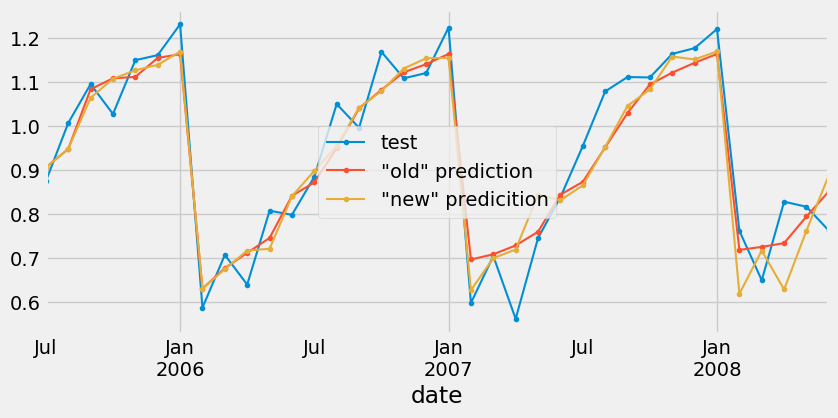

In [34]:
fig, ax = plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test', marker = 'o', markersize = 3)
predictions['pred'].plot(ax=ax, label='"old" prediction', marker = 'o', markersize = 3)
y_pred.plot(ax=ax, label='"new" predicition', marker = 'o', markersize = 3)
ax.legend();

## Recursive autoregressive forecasting with exogenous variables

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios,  it is possible to have information about other variables, whose future value is known, so could serve as additional predictors in the model.



Restore the original dataset: it contains also two exogenous variables.

In [35]:
data

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


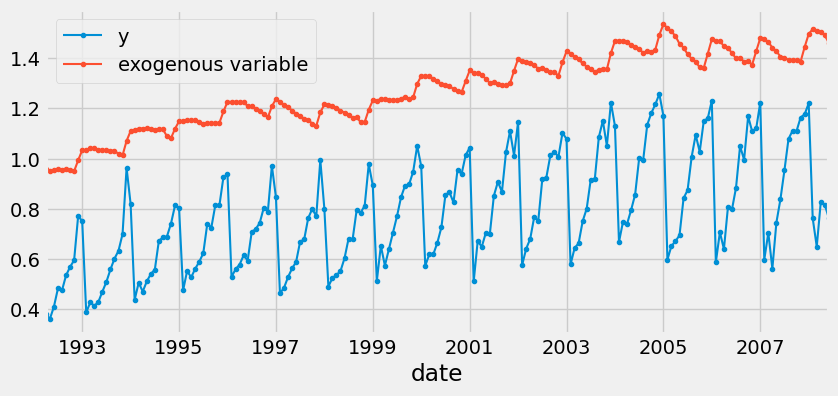

In [36]:
fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='y',marker = 'o', markersize = 3)
data['exog_1'].plot(ax=ax, label='exogenous variable',marker = 'o', markersize = 3)
ax.legend();

In [37]:
# Split data into train-test
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


### ForecasterAutoreg

In [38]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-14 16:15:54 
Last fit date: 2022-12-14 16:15:54 
Skforecast version: 0.6.0 
Python version: 3.10.8 

### Predictions
If the `ForecasterAutoreg` is trained with an exogenous variable, the value of this variable must be passed to `predict()` as well. 

**Note:** it is only applicable to scenarios in which future information on the exogenous variable is available.

In [39]:
# Predictions
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

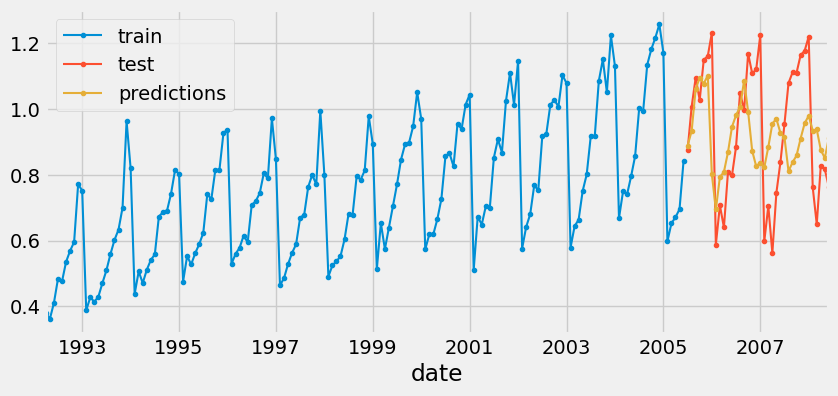

In [40]:
# Plot
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train',marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test',marker = 'o', markersize = 3)
predictions.plot(ax=ax, label='predictions',marker = 'o', markersize = 3)
ax.legend();

### Prediction error in the test set

In [41]:
# Test error
error_mse = mean_squared_error(y_true = data_test['y'],y_pred = predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


### Hyperparameter tuning

In [42]:
# Hyperparameter Grid search
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train['exog_1'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 27.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:17<00:00,  5.69s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.007172428407773492



In [43]:
# Grid Search results
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.007172,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.007176,10,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.007535,10,500
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 500}",0.007960,5,500
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",0.008168,5,100
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",0.008383,5,50
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",0.008696,3,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 500}",0.008745,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.008832,3,50
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.008944,5,50


The best results are obtained using a time window of 12 lags and a Random Forest set up of {'max_depth': 10, 'n_estimators': 50}.

### Final model
Setting `return_best = True` in `grid_search_forecaster`, after the search, the `ForecasterAutoreg` object has been modified and trained with the best configuration found.

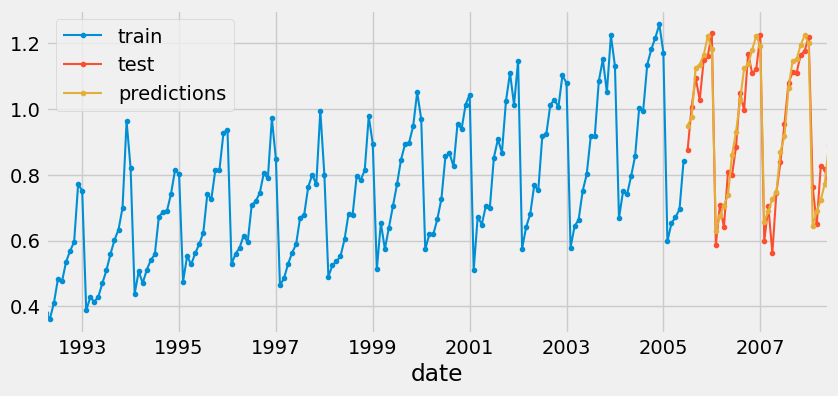

In [44]:
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train',marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test',marker = 'o', markersize = 3)
predictions.plot(ax=ax, label='predictions',marker = 'o', markersize = 3)
ax.legend();

In [45]:
# Test error
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.0044949967759907675


Compared to the previous setting, with different parameters configuration and without exogenous variables, there is no improvement in test MSE.

Previous test error (mse): 0.004255953572840445

**Note**: in this example we have used only one exogenous variable (*exog_1*), and passed to fit as a `pd.Series`. However, you can include more than one variable (e.g., also *exog_2*) as long as they have the same number of observations as y and are aligned with the target time series (i.e., y[i] is regressed on exog[i]). You can do so by passing a `pd.DataFrame` (or a `np.ndarray`) to the fit method.

## Recursive autoregressive forecasting with custom predictors

In addition to the lags, it may be interesting to incorporate other characteristics of the time series in some scenarios. For example, the moving average of the last *n* values could be used to capture the series's trend.

The `ForecasterAutoregCustom` class behaves very similar to the `ForecasterAutoreg` class seen in the previous sections, but with the difference that it is the user who defines the function used to create the predictors.

The first example of the document about predicting the last 36 months of the time series is repeated. In this case, the predictors are the first 10 lags and the values' moving average of the lasts 20 months.

### ForecasterAutoregCustom
A `ForecasterAutoregCustom` is created and trained from a `RandomForestRegressor` regressor. The `create_predictor()` function,  which calculates the first 10 lags and the moving average of the last 20 values, is used to create the predictors.

In [46]:
# Function to calculate predictors from time series
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    window = 20
    lags = y[-1:-16:-1] # first ten items are lags from lag-1 to lag-15
    mean = np.mean(y[-window:]) # sixteenth item is the moving average
    predictors = np.hstack([lags, mean])
    
    return predictors

When creating the forecaster, the `window_size` argument must be equal to, or greater than, the window used by the function that creates the predictors.

In [47]:
# Create and train forecaster
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(max_depth = 5, n_estimators = 200, random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20 # (int) — Size of the window needed by fun_predictors to create the predictors.
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(max_depth=5, n_estimators=200, random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-14 16:16:12 
Last fit date: 2022-12-14 16:16:12 
Skforecast version: 0.

Using the method `create_train_X_y`, is it posible to acces the matrices that are created internally in the training process.

In [48]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(5).T

date,1993-12-01,1994-01-01,1994-02-01,1994-03-01,1994-04-01
custom_predictor_0,0.699605,0.963081,0.819325,0.437670,0.506121
custom_predictor_1,0.632947,0.699605,0.963081,0.819325,0.437670
custom_predictor_2,0.601514,0.632947,0.699605,0.963081,0.819325
custom_predictor_3,0.558443,0.601514,0.632947,0.699605,0.963081
custom_predictor_4,0.509210,0.558443,0.601514,0.632947,0.699605
custom_predictor_5,0.470126,0.509210,0.558443,0.601514,0.632947
custom_predictor_6,0.428859,0.470126,0.509210,0.558443,0.601514
custom_predictor_7,0.413890,0.428859,0.470126,0.509210,0.558443
custom_predictor_8,0.427283,0.413890,0.428859,0.470126,0.509210
custom_predictor_9,0.387554,0.427283,0.413890,0.428859,0.470126


Custom_predictor_15 is the moving average value.

In [49]:
y.head(4)

date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
Freq: MS, Name: y, dtype: float64

### Predictions

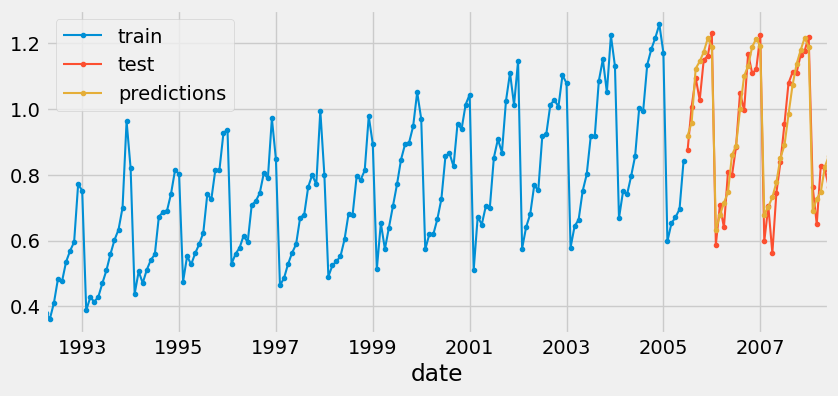

In [50]:
steps = 36
predictions = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train', marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test', marker = 'o', markersize = 3)
predictions.plot(ax=ax, label='predictions', marker = 'o', markersize = 3)
ax.legend();

### Prediction error in the test set

In [51]:
error_mse = mean_squared_error(y_true = data_test['y'],y_pred = predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00423273168544706


**Note**: Unfortunately, due to the inner working of the current implementation of `ForecasterAutoregCustom`, we cannot specify the `lags_grid` argument in `grid_search_forecaster` 

## Direct multi-step forecasting

The `ForecasterAutoreg` and `ForecasterAutoregCustom` models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the `ForecasterAutoregDirect` class and can include one or multiple exogenous variables.

### ForecasterAutoregDirect
Unlike when using `ForecasterAutoreg` or `ForecasterAutoregCustom`, the number of steps to be predicted must be indicated in the `ForecasterAutoregDirect` models with the `steps` parameter (*maximum number of future steps the forecaster will predict when using method predict()*). Since a different model is created for each step, this value should be defined before training.
This means that the number of predictions obtained when executing the `predict()` method is always the same. It is not possible to predict steps beyond the value defined at their creation.

For this example, a linear model (`Lasso`) is used as a regressor. It consists of a linear model with an added L1 regularization term. 

We also standardize the predictors, thus combining the regressor with `StandardScaler` as a transformer. For more detailed documentation how to use transformers and pipelines, visit: [skforecast with scikit-learn and transformers pipelines](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html).

In [52]:
# Hyperparameter Grid search
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # This value will be replaced in the grid search
             )

# If a pipeline is used, access parameters using the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.021544346900318846}
  Backtesting metric: 0.01309677527145483



In [53]:
# Grid Search results
results_grid.head()

,lags,params,mean_squared_error,alpha
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},0.013097,0.021544
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.021544346900318846},0.013681,0.021544
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},0.014560,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},0.014647,0.000129
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1e-05},0.014649,0.000010


The best results are obtained using a time window of 12 lags and a Lasso setting {'alpha': 0.021544}.

In [54]:
forecaster

ForecasterAutoregDirect 
Regressor: Lasso(alpha=0.021544346900318846, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Included weights function: False 
Window size: 12 
Maximum steps predicted: 36 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.021544346900318846, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
Creation date: 2022-12-14 16:16:12 
Last fit date: 2022-12-14 16:16:14 
Skforecast version: 0.6.0 
Python version: 3.10.8 

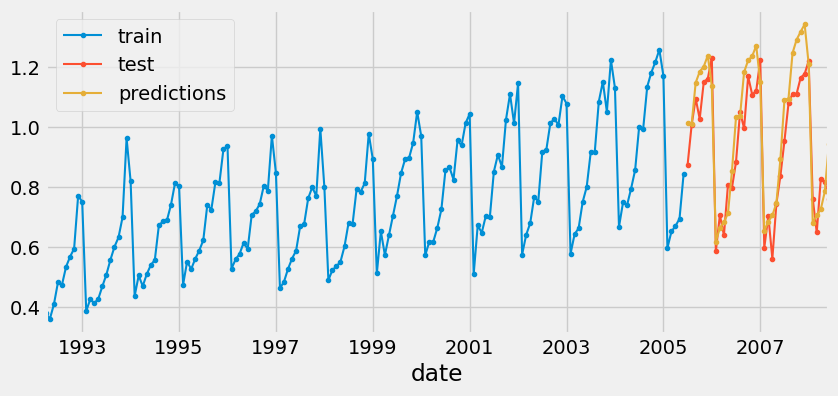

In [55]:
predictions = forecaster.predict()
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train', marker = 'o', markersize = 3)
data_test['y'].plot(ax=ax, label='test', marker = 'o', markersize = 3)
predictions.plot(ax=ax, label='predictions', marker = 'o', markersize = 3)
ax.legend();

In [56]:
# Test error
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.010777156130592202
